## Умова лабораторної роботи

### Модель класифікації

Побудувати моделi класифiкацiї на основi методу дерев рiшень, використовуючи  `sklearn.neural_network.MLPClassifier`з рiзними значеннями гiперпараметрiв.

### Початкові дані та Завдання

Див. lab2.

## `MLPClassifier`

Multi-layer Perceptron - контрольований алгоритм навчання, який вивчає функцію $f:R^m\rightarrow R^o$ навчаючись на наборі даних, де кількість вимірів для введення та це кількість вимірів для виведення. Дано набір ознак $X=x_1,\ldots,x_m$ і цільову змінну $y$, він може вивчати апроксиматор нелінійної функції для класифікаці. Відрізняється від логістичної регресії тим, що між вхідним і вихідним шарами може бути один або кілька нелінійних шарів, які називаються прихованими шарами. На малюнку нижче показано MLP одного прихованого шару зі скалярним виходом.

Вхідний шар складається з набору нейронів $\{x_i|x_1,\ldots,x_m\}$ що представляє вхідні функції. Кожен нейрон у прихованому шарі перетворює значення з попереднього шару за допомогою зваженого лінійного підсумовування $\sum\limits_{i=1}^m\omega_i x_i$ а потім обраховується нелінійна функція активації $g(\cdot):R\rightarrow R$

Рекомендації щодо практичного використання MLP:
* Багатошаровий Perceptron чутливий до масштабування функцій, тому настійно рекомендується масштабувати дані $X$. Наприклад, до [0, 1] або [-1, +1] або стандартизуйте його, щоб мати середнє значення 0 і дисперсію 1.
* LBFGS збігається швидше та з кращими рішеннями на невеликих наборах даних. Однак для відносно великих наборів даних Adam дуже надійний. Зазвичай він швидко сходиться і дає досить хорошу продуктивність. SGD з імпульсом або імпульсом Нестерова, з іншого боку, може працювати краще, ніж ці два алгоритми, якщо швидкість навчання налаштована правильно.

##  Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    PrecisionRecallDisplay,
    precision_recall_fscore_support,
    RocCurveDisplay,
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline


## Websites

### Download & EDA

In [2]:
websites_train = pd.read_csv("../lab2/data/websites_train.csv")
websites_test = pd.read_csv("../lab2/data/websites_test.csv")

### Finetuning

In [3]:
websites_train.describe().T

,count,mean,std,min,25%,50%,75%,max
DNS_QUERY_TIMES,1040.0,2.277885,2.889810,0.000000,0.000000,0.000000,4.000000,14.000000
WHOIS_UPDATED_DATE - WHOIS_REGDATE,1040.0,114493.280757,54560.144252,0.000000,79032.000000,122724.000000,157020.000000,227808.000000
NUMBER_SPECIAL_CHARACTERS / URL_LENGTH,1040.0,0.199806,0.035392,0.082051,0.177778,0.196078,0.217391,0.411765
REMOTE_APP_PACKETS / SOURCE_APP_PACKETS,1040.0,0.680472,0.570401,0.000000,0.000000,0.857143,1.000000,3.000000
REMOTE_IPS / DIST_REMOTE_TCP_PORT,1040.0,0.896968,1.253871,0.000000,0.000000,0.400000,1.333333,9.000000
Type,1040.0,0.110577,0.313758,0.000000,0.000000,0.000000,0.000000,1.000000


In [4]:
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer

scaler = MinMaxScaler()
scaler.fit(websites_train.drop(columns="Type").values)
scaler_transformer = FunctionTransformer(scaler.transform, validate=True)
pipeline = make_pipeline(
    scaler_transformer,  
    MLPClassifier()
)

grid_search_1 = GridSearchCV(
    estimator=pipeline,
    param_grid={
        "mlpclassifier__solver": ["adam", "lbfgs"],
        "mlpclassifier__activation": ["tanh","logistic"],
        "mlpclassifier__hidden_layer_sizes": [(4,),(2,)],
        "mlpclassifier__learning_rate": ["adaptive", "constant"],
        "mlpclassifier__max_iter": [500],
        "mlpclassifier__tol": [1e-3],
        "mlpclassifier__early_stopping": [True],
    },
    scoring="f1_macro",
    cv=3,
    verbose=1,
    error_score='raise'
)

In [5]:
%%time
_ = grid_search_1.fit(
    websites_train.drop(columns=["Type"]).values,
    websites_train["Type"].values
)
print(f"best parameters: {grid_search_1.best_params_}")
print(f"f1 macro: {grid_search_1.best_score_:.4f}",)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best parameters: {'mlpclassifier__activation': 'logistic', 'mlpclassifier__early_stopping': True, 'mlpclassifier__hidden_layer_sizes': (4,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__max_iter': 500, 'mlpclassifier__solver': 'lbfgs', 'mlpclassifier__tol': 0.001}
f1 macro: 0.8441
CPU times: total: 4.69 s
Wall time: 4.54 s


### Evaluation

Precision macro: 0.8811
Recall macro: 0.7369
F1 macro: 0.7872
Confusion matrix:
[[610   8]
 [ 39  37]]


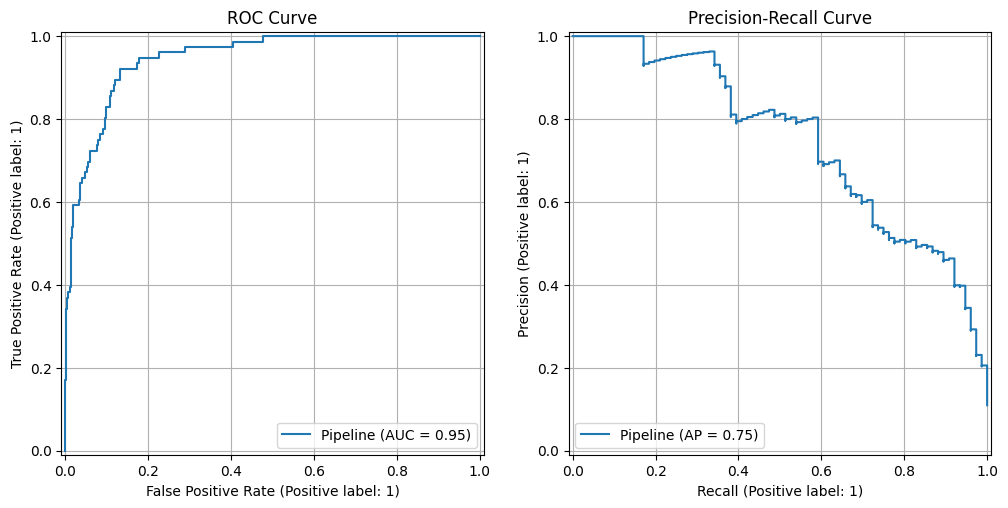

In [6]:
y_test_websites_pred = grid_search_1.best_estimator_.predict(websites_test.drop(columns=["Type"]).values)

precision, recall, f1, _ = precision_recall_fscore_support(
    websites_test["Type"].values,
    y_test_websites_pred,
    average="macro"
)

print(f"Precision macro: {precision:.4f}")
print(f"Recall macro: {recall:.4f}")
print(f"F1 macro: {f1:.4f}")
print(f"Confusion matrix:\n{confusion_matrix(websites_test["Type"],y_test_websites_pred)}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

RocCurveDisplay.from_estimator(
    grid_search_1.best_estimator_,
    websites_test.drop(columns=["Type"]).values,
    websites_test["Type"],
    ax=axes[0]
)
axes[0].set_title("ROC Curve")
axes[0].grid(True)


PrecisionRecallDisplay.from_estimator(
    grid_search_1.best_estimator_,
    websites_test.drop(columns=["Type"]).values,
    websites_test["Type"],
    ax=axes[1],
)

axes[1].set_title("Precision-Recall Curve")
axes[1].grid(True)

## XOR

### Download & EDA

In [7]:
xor_train = pd.read_csv("../lab2/data/xor_train.csv")
xor_test = pd.read_csv("../lab2/data/xor_test.csv")

In [8]:
xor_train.describe()

,X1,X2,Y
count,180.000000,180.000000,180.000000
mean,-0.048137,-0.051700,0.472222
std,1.048968,0.949213,0.500620
min,-2.552990,-2.772593,0.000000
25%,-0.731674,-0.660788,0.000000
50%,-0.218245,-0.043426,0.000000
75%,0.733615,0.542720,1.000000
max,2.696224,2.256723,1.000000


### Finetuning

In [9]:
grid_search_2 = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid={
        "solver": ["lbfgs", "adam"],
        "activation": ["tanh", "logistic"],
        "hidden_layer_sizes":  [(4,), (3,)],
        "learning_rate": ["invscaling", "adaptive"],
        "alpha": [0.1],
        "early_stopping": [True],
        "tol": [1e-3]
    },
    scoring=["f1"],
    refit="f1",
    cv=3,
    verbose=1,
    error_score='raise'
)

In [10]:
%%time
_ = grid_search_2.fit(
    xor_train[["X1", "X2"]],
    xor_train["Y"]
)

print(f"best parameters: {grid_search_2.best_params_}")
print(f"f1: {grid_search_2.best_score_:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
best parameters: {'activation': 'logistic', 'alpha': 0.1, 'early_stopping': True, 'hidden_layer_sizes': (4,), 'learning_rate': 'invscaling', 'solver': 'lbfgs', 'tol': 0.001}
f1: 0.9661
CPU times: total: 2.19 s
Wall time: 3.18 s


### Evaluation

Precision: 0.8769
Recall: 1.0000
F1: 0.9344
Confusion matrix:
[[55  8]
 [ 0 57]]


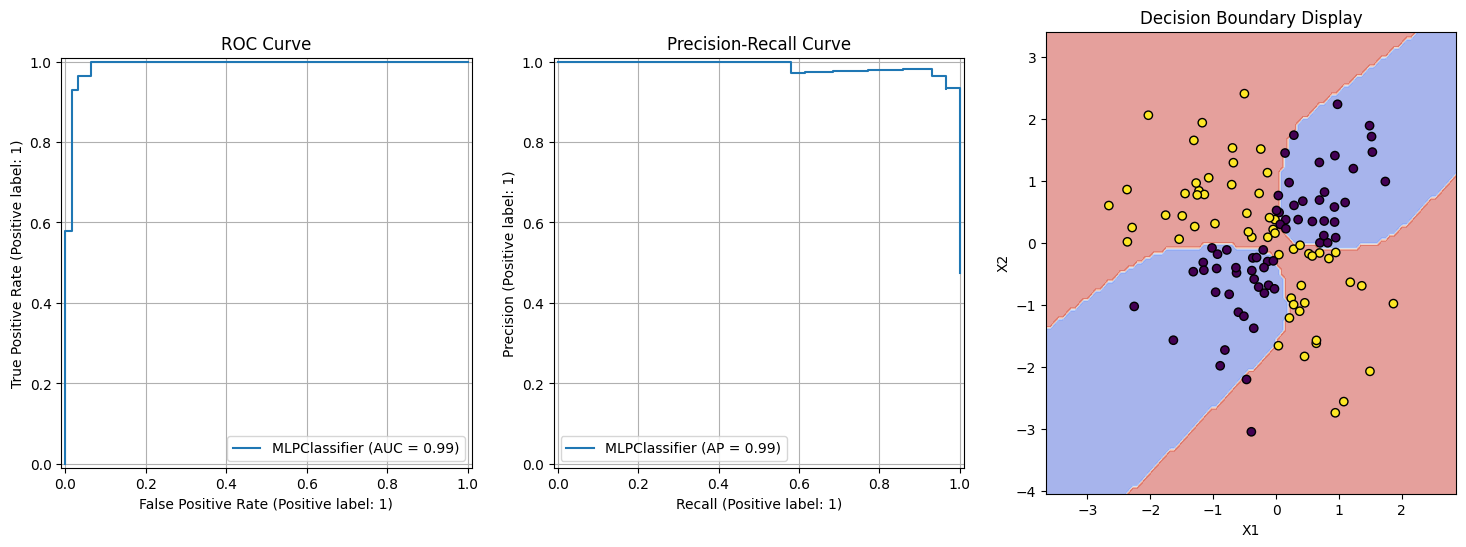

In [11]:
y_test_xor_pred = grid_search_2.best_estimator_.predict(xor_test[["X1", "X2"]])


precision, recall, f1, _ = precision_recall_fscore_support(
    xor_test["Y"],
    y_test_xor_pred,
    average='binary' 
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")
print(f"Confusion matrix:\n{confusion_matrix(xor_test["Y"],y_test_xor_pred)}")


fig, axes = plt.subplots(1, 3, figsize=(18, 6))

RocCurveDisplay.from_estimator(
    grid_search_2.best_estimator_,
    xor_test[["X1", "X2"]],
    xor_test["Y"],
    ax=axes[0]
)
axes[0].set_title("ROC Curve")
axes[0].grid(True)

PrecisionRecallDisplay.from_estimator(
    grid_search_2.best_estimator_,
    xor_test[["X1", "X2"]],
    xor_test["Y"],
    ax=axes[1]
)
axes[1].set_title("Precision-Recall Curve")
axes[1].grid(True)


disp = DecisionBoundaryDisplay.from_estimator(
    grid_search_2.best_estimator_,
    xor_test[["X1", "X2"]],
    response_method="predict",
    xlabel="X1",
    ylabel="X2",
    alpha=0.5,
    cmap="coolwarm",
    ax=axes[2]
)
axes[2].set_title("Decision Boundary Display")
disp.ax_.scatter(xor_test["X1"], xor_test["X2"], c=xor_test["Y"], edgecolor="k")

## Висновки

Порівнянно з lab.2, значення метрик мережі, натренованої на наборі про вебсайти, погіршилися, проте для мережі, натренованої на наборі XOR значно покращилися, та вирішилася проблема XOR, як видно з границь рішень.